QUBO Problem on Gate model with Adiabatic Model

In [1]:
import numpy as np
from typing import Literal
from tem import * 

def qubo_index(i, N, zero=True):
    max = N*(N-1)/2
    if i > max or i<1:
        return None
    
    for j in range(1, N+1):
        Nj = N-j
        if i > Nj:
            i -= Nj
        else:
            if zero:
                return (j-1, j+i-1)
            return (j, j+i)


In [2]:
kernel = lambda i,j : 1/(1+(i -j)**2)
n0 = 7
K = np.fromfunction(kernel, (n0, n0))
D = diff_matrix_three_point(n0, t="") # difference matrix

In [3]:
# QUBO formulation
L = D@K
M = L.T@L
n0 = M.shape[0]
save_M00 = M[0,0]

i, j = np.indices(M.shape)

# Adjust the principal axis effect 
# to reduce possiblity of trivial solution, all zero and ones. 
M[i==j] = 0.5

q_r_diff = M.diagonal()
J_r_diff = M[np.triu_indices(n0, k = 1)]

linear_r = { (i, i): q_r_diff[i] for i in range(0,n0)}
in_list_r= [qubo_index(i, n0) for i in range(1, int(n0*(n0-1)/2)+1)]
quadratic_r = { in_list_r[i]: M[*in_list_r[i]] for i in range(0, int(n0*(n0-1)/2))}

Quad = {**linear_r, **quadratic_r}

In [4]:
import pennylane as qml

In [5]:
# Gate model setting
# Circuit setting
n_wires = n0
wires = range(n_wires)

basis_hamiltonian_initial = [qml.PauliX(i) for i in range(0, n0)]

basis_hamiltonian_dig = [qml.PauliZ(i) for i in range(0, n0)]
basis_hamiltonian_off = [qml.PauliZ(i)@qml.PauliZ(j) for (i, j) in in_list_r]

# Adabatic parameter setting
mu = 10 # Initial hamitlonian weight
coeff_X = n0*[-mu] # pauli x coeff

# Below solution hamiltonian

#M[i==j] = save_M00 # restore the original quadratic form
M[i==j] = 0
dig_coeff = list(np.sqrt(M.diagonal()))
off_coeff = [M[i, j] for (i, j) in in_list_r]

coeff = np.array(coeff_X + dig_coeff + off_coeff)
basis_hamiltonian = basis_hamiltonian_initial + basis_hamiltonian_dig + basis_hamiltonian_off

In [6]:
H_init = qml.Hamiltonian(-np.ones(n0), basis_hamiltonian_initial)
H_solve = qml.Hamiltonian(dig_coeff+off_coeff ,basis_hamiltonian_dig + basis_hamiltonian_off)

# Anealer D-Wave

In [7]:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler())

In [8]:
samples_d_wave= sampler.sample_qubo(
    Quad, 
    num_reads=1000)

In [9]:
print(samples_d_wave.record[0:5])

[([1, 1, 0, 1, 0, 1, 1], -4.56076492, 797, 0.)
 ([1, 1, 0, 1, 1, 1, 1], -4.07514442,  46, 0.)
 ([1, 1, 1, 1, 0, 1, 1], -4.07514442,  88, 0.)
 ([1, 1, 1, 1, 1, 1, 1], -3.98481804,  52, 0.)
 ([1, 1, 1, 0, 1, 1, 1], -3.71677108,  14, 0.)]


# Gate Model simulator

In [10]:
from matplotlib import pyplot as plt

In [11]:
from pennylane.templates import ApproxTimeEvolution

In [12]:
dev_local_sim = qml.device('default.qubit', wires=n_wires, shots=500)

In [13]:
@qml.qnode(dev_local_sim)
def circuit_time_evolve(time, initial_weight, 
                        steps=5, trroter_num=2 ,
                        mode="exp", Hamiltonian=H_solve):
    
    n_list = [i for i in range(0,n0)]
    for i in n_list:
        qml.Hadamard(wires=i)
    
    #qml.Hadamard(wires=n_list)

    dt = time/steps
    n1 = int(n0*(n0+1)/2)
    
    if initial_weight <0:
        initial_weight = -initial_weight
    coeff_X = n0*[-initial_weight]
    coeff = np.array(coeff_X + dig_coeff + off_coeff)
    
    for i in range(0, steps+1):
        t = i*dt/time
        t_evol = np.array(n0*[1-t] + n1*[t])
        t_coeff = t_evol * coeff
        H_t = qml.Hamiltonian(t_coeff, basis_hamiltonian)
        
        ApproxTimeEvolution(H_t, dt, trroter_num)
    if mode=="exp":
        return qml.expval(Hamiltonian)
    elif mode=="count":
        return qml.counts()
    elif mode =="prob":
        return qml.probs(n_list)

In [14]:
T = 3.5
iw=  5
steps = 20
trroter_num =2

In [18]:
spec = qml.specs(circuit_time_evolve)(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="prob")
spec["depth"]

/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/pennylane/gradients/gradient_transform.py:290: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/pennylane/tape/qscript.py:1425: UserWarning: The depth key is deprecated and will be removed in the next release. Going forward, please use: specs["resources"].depth
  warnings.warn(


22

In [39]:
prob_n = circuit_time_evolve(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="prob")
prob_n

array([0.078, 0.   , 0.004, 0.006, 0.07 , 0.002, 0.   , 0.002, 0.024,
       0.   , 0.004, 0.024, 0.   , 0.   , 0.   , 0.006, 0.036, 0.   ,
       0.014, 0.018, 0.086, 0.002, 0.   , 0.032, 0.   , 0.   , 0.004,
       0.034, 0.002, 0.   , 0.   , 0.004, 0.004, 0.   , 0.   , 0.   ,
       0.01 , 0.   , 0.   , 0.   , 0.008, 0.   , 0.002, 0.012, 0.006,
       0.   , 0.   , 0.004, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.012, 0.002, 0.   , 0.004, 0.002, 0.   ,
       0.002, 0.008, 0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.01 , 0.004, 0.   , 0.004, 0.012, 0.002, 0.008, 0.092,
       0.028, 0.01 , 0.   , 0.054, 0.   , 0.   , 0.   , 0.002, 0.024,
       0.008, 0.   , 0.028, 0.   , 0.   , 0.   , 0.07 , 0.   , 0.002,
       0.   , 0.11 ]

In [40]:
def get_state_strings(n):
    total_n = 2**n
    
    st = []
    for i in range(0, total_n):
        str_num = format(i, 'b')
        st.append((n-len(str_num))*"0" + str_num)
    return st

In [41]:
state_marks = np.array(get_state_strings(7))

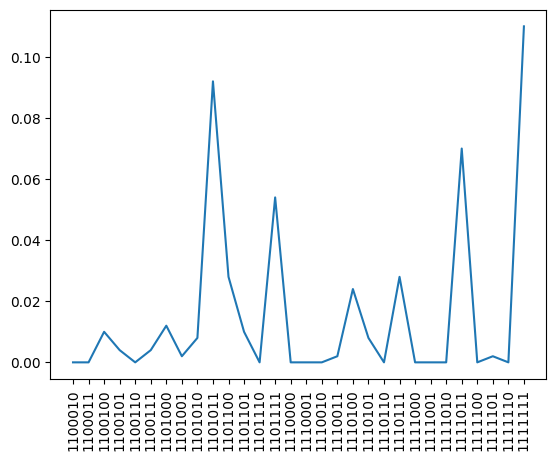

In [42]:
plt.plot(state_marks[-30:], prob_n[-30:])
plt.xticks(rotation = 90)
plt.show()

In [43]:
sample = circuit_time_evolve(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="count")

In [44]:
sample_keys = np.array(list(sample.keys()))
sample_vals = np.array(list(sample.values()))

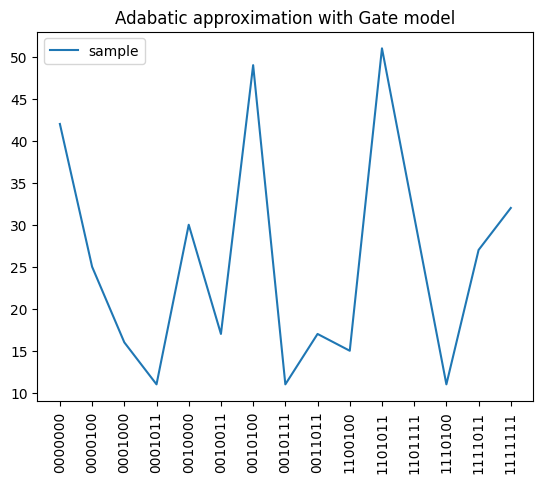

In [45]:
N =10
plt.plot(sample_keys[sample_vals>N], sample_vals[sample_vals>N])
plt.xticks(rotation = 90)
plt.title("Adabatic approximation with Gate model")
#plt.vlines(17, 0, 0.2, colors=["k"])
plt.legend(["sample", "annealer optimal point"], loc=2)
plt.show()

# IBM Q computer Running

**Prerequisites**

* IBM Quantum account and its API token

Assume that you already installed `pennylane` package, you need next packages to run your Pennylane circuit on IBM quantum computer.

* qiskit
* qiskit-aear
* pennylane-qiskit

```
pip install qiskit, qiskit-aear, pennylane-qiskit
```

After you generate account on IBM server and get api token, save the configuration to your local qiskit environment.

In [46]:
from qiskit import IBMQ

In [47]:
#IBMQ.save_account("yout token value")

When you finished the above configuration, you can use IBM backends on your local python environment without additional account configuration.

Let's see some possible backends of IBMQ.

In [48]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2023-08-08 11:40:38,943: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

`IBMQSimulator` is a HPC qubit simulator class and `IBMQBackend` is a real quantum devices class.

Choose one of the backend and make Pennylane `device` as like your previous codes.

In [49]:
dev_ibmq = qml.device(
    "qiskit.ibmq", wires=7, 
    backend='ibmq_qasm_simulator', 
    provider=provider, 
    shots= 1000,
    #ibmqx_token=ibmq_token
    )

In [50]:
@qml.qnode(dev_ibmq)
def circuit_time_evolve_IBM(time, initial_weight, 
                        steps=5, trroter_num=2 ,
                        mode="exp", Hamiltonian=H_solve):
    
    n_list = [i for i in range(0,n0)]
    for i in n_list:
        qml.Hadamard(wires=i)
    
    #qml.Hadamard(wires=n_list)

    dt = time/steps
    n1 = int(n0*(n0+1)/2)
    
    if initial_weight <0:
        initial_weight = -initial_weight
    coeff_X = n0*[-initial_weight]
    coeff = np.array(coeff_X + dig_coeff + off_coeff)
    
    for i in range(0, steps+1):
        t = i*dt/time
        t_evol = np.array(n0*[1-t] + n1*[t])
        t_coeff = t_evol * coeff
        H_t = qml.Hamiltonian(t_coeff, basis_hamiltonian)
        
        ApproxTimeEvolution(H_t, dt, trroter_num)
    if mode=="exp":
        return qml.expval(Hamiltonian)
    elif mode=="count":
        return qml.counts()
    elif mode =="prob":
        return qml.probs(n_list)

In [52]:
T = 3.5
iw=  5
steps = 20
trroter_num =2

Run quantum circuit on real quantum device may takes several minutes or hours. The circuit will be registered on work queue of each device and treated sequentially.

While they are on the queue, you can see the IBMQ dashboard and there is a queued task. You can also see qiskit and qasm version of your circuit on the dashboard.

In [53]:
probs = circuit_time_evolve_IBM(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="prob")

In [54]:
probs

array([0.096, 0.   , 0.   , 0.001, 0.064, 0.002, 0.   , 0.001, 0.032,
       0.002, 0.006, 0.026, 0.005, 0.   , 0.   , 0.001, 0.048, 0.001,
       0.012, 0.017, 0.099, 0.007, 0.   , 0.023, 0.002, 0.   , 0.002,
       0.017, 0.001, 0.   , 0.   , 0.002, 0.002, 0.   , 0.   , 0.   ,
       0.011, 0.001, 0.   , 0.   , 0.009, 0.   , 0.002, 0.008, 0.005,
       0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.002,
       0.   , 0.   , 0.001, 0.013, 0.002, 0.   , 0.004, 0.001, 0.   ,
       0.   , 0.012, 0.   , 0.002, 0.   , 0.002, 0.007, 0.   , 0.001,
       0.   , 0.024, 0.001, 0.   , 0.   , 0.015, 0.001, 0.005, 0.084,
       0.02 , 0.012, 0.   , 0.04 , 0.   , 0.   , 0.002, 0.001, 0.021,
       0.011, 0.   , 0.035, 0.001, 0.   , 0.001, 0.059, 0.003, 0.003,
       0.002, 0.101]

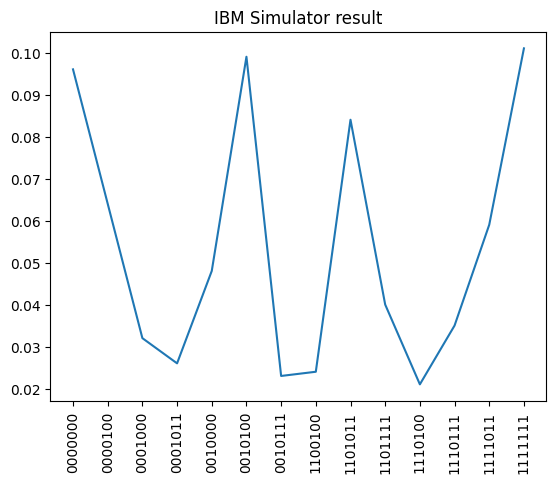

In [55]:
p=0.02
plt.plot(state_marks[probs>p], probs[probs>p])
plt.xticks(rotation = 90)
plt.title("IBM Simulator result")
plt.show()

In [119]:
dev_ibmq_nairobi = qml.device(
    "qiskit.ibmq", wires=7, 
    backend='ibm_nairobi', 
    provider=provider, 
    shots= 1000,
    #ibmqx_token=ibmq_token
    )

In [120]:
@qml.qnode(dev_ibmq_nairobi)
def circuit_time_evolve_IBM_real(time, initial_weight, 
                        steps=5, trroter_num=2 ,
                        mode="exp", Hamiltonian=H_solve):
    
    n_list = [i for i in range(0,n0)]
    for i in n_list:
        qml.Hadamard(wires=i)
    
    #qml.Hadamard(wires=n_list)

    dt = time/steps
    n1 = int(n0*(n0+1)/2)
    
    if initial_weight <0:
        initial_weight = -initial_weight
    coeff_X = n0*[-initial_weight]
    coeff = np.array(coeff_X + dig_coeff + off_coeff)
    
    for i in range(0, steps+1):
        t = i*dt/time
        t_evol = np.array(n0*[1-t] + n1*[t])
        t_coeff = t_evol * coeff
        H_t = qml.Hamiltonian(t_coeff, basis_hamiltonian)
        
        ApproxTimeEvolution(H_t, dt, trroter_num)
    if mode=="exp":
        return qml.expval(Hamiltonian)
    elif mode=="count":
        return qml.counts()
    elif mode =="prob":
        return qml.probs(n_list)

In [121]:
T = 3.5
iw=  5
steps = 20
trroter_num =2

In [122]:
probs_real = circuit_time_evolve_IBM_real(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="prob")
probs_real

array([0.038, 0.016, 0.017, 0.017, 0.017, 0.011, 0.011, 0.01 , 0.031,
       0.012, 0.018, 0.015, 0.01 , 0.013, 0.011, 0.012, 0.019, 0.015,
       0.015, 0.01 , 0.006, 0.009, 0.006, 0.002, 0.016, 0.009, 0.007,
       0.01 , 0.009, 0.012, 0.001, 0.006, 0.015, 0.016, 0.015, 0.011,
       0.016, 0.011, 0.008, 0.007, 0.032, 0.017, 0.019, 0.009, 0.01 ,
       0.004, 0.009, 0.008, 0.01 , 0.017, 0.008, 0.01 , 0.008, 0.002,
       0.005, 0.007, 0.007, 0.012, 0.001, 0.004, 0.005, 0.007, 0.003,
       0.008, 0.01 , 0.005, 0.007, 0.004, 0.01 , 0.003, 0.005, 0.003,
       0.012, 0.007, 0.012, 0.003, 0.002, 0.007, 0.   , 0.002, 0.007,
       0.007, 0.005, 0.002, 0.002, 0.005, 0.002, 0.005, 0.005, 0.004,
       0.005, 0.004, 0.003, 0.004, 0.002, 0.004, 0.005, 0.005, 0.011,
       0.006, 0.002, 0.003, 0.004, 0.003, 0.006, 0.004, 0.003, 0.002,
       0.005, 0.006, 0.004, 0.001, 0.005, 0.003, 0.005, 0.004, 0.001,
       0.001, 0.002, 0.001, 0.003, 0.002, 0.003, 0.003, 0.005, 0.   ,
       0.002, 0.   ]

In [56]:
probs_real_save = np.array([0.038, 0.016, 0.017, 0.017, 0.017, 0.011, 0.011, 0.01 , 0.031,
       0.012, 0.018, 0.015, 0.01 , 0.013, 0.011, 0.012, 0.019, 0.015,
       0.015, 0.01 , 0.006, 0.009, 0.006, 0.002, 0.016, 0.009, 0.007,
       0.01 , 0.009, 0.012, 0.001, 0.006, 0.015, 0.016, 0.015, 0.011,
       0.016, 0.011, 0.008, 0.007, 0.032, 0.017, 0.019, 0.009, 0.01 ,
       0.004, 0.009, 0.008, 0.01 , 0.017, 0.008, 0.01 , 0.008, 0.002,
       0.005, 0.007, 0.007, 0.012, 0.001, 0.004, 0.005, 0.007, 0.003,
       0.008, 0.01 , 0.005, 0.007, 0.004, 0.01 , 0.003, 0.005, 0.003,
       0.012, 0.007, 0.012, 0.003, 0.002, 0.007, 0.   , 0.002, 0.007,
       0.007, 0.005, 0.002, 0.002, 0.005, 0.002, 0.005, 0.005, 0.004,
       0.005, 0.004, 0.003, 0.004, 0.002, 0.004, 0.005, 0.005, 0.011,
       0.006, 0.002, 0.003, 0.004, 0.003, 0.006, 0.004, 0.003, 0.002,
       0.005, 0.006, 0.004, 0.001, 0.005, 0.003, 0.005, 0.004, 0.001,
       0.001, 0.002, 0.001, 0.003, 0.002, 0.003, 0.003, 0.005, 0.   ,
       0.002, 0.   ])

In [ ]:
state_marks

In [70]:
p_real = 0.012
p_index = (probs_real_save>p_real)

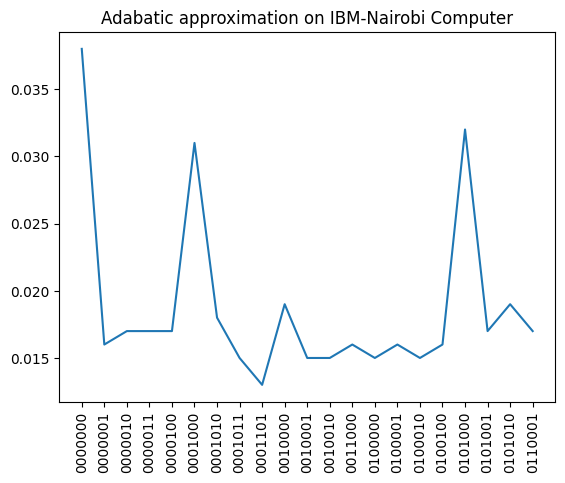

In [71]:
plt.plot(state_marks[p_index], probs_real_save[p_index])
plt.xticks(rotation = 90)
plt.title("Adabatic approximation on IBM-Nairobi Computer")
plt.show()

The real quantum processor showed inconsistance with simulation device result. 

That is because there gate operation has some significant errors.